# Mathematical Statistics Homework Assignment
#### 2023.05
#### Richárd Kiss - KAYXFT

# 1. Introduction

In this assignment I use a dataset that was generated as part of my PhD research. The dataset contains music playlists and song recommendations for these playlists generated with two different algorithms. In this assignment I am performing statistical analysis to compare these two algorithms in terms of recommendation performance.

## The two recommendation algorithms
### Algorithm 1.
The first algorithm recommends songs based solely on their popularity. It consistently returns the top $K$ most popular songs, irrespective of the particular songs present in the playlist for which we are making new song recommendations. Despite its simplicity, this approach is very effective and often used as a benchmark in the evaluation of recommendation systems.

### Algorithm 2.
The second algorithm employs Skip-Gram with negative sampling to learn insightful, low-dimensional song representations (denoted by $w_i \in \mathbb{R}^l$ for all songs $i$, where $l$ is the dimensionality of the representation). The core concept revolves around discerning whether song pairs originate from the original data distribution, $P_{orig}$, or from a synthetic noise distribution, $P_{noise}$.

The song pairs in the original distribution are generated by sampling songs from a playlist within a specific context window (of size $c$), and corresponding noise samples are created by randomly pairing songs that do not appear together within a context window (of the same size $c$).

To reduce computational demands, we ease the restriction of never appearing together. Since the co-appearance graph of songs is usually sparse, choosing two random songs seldom results in a pair that co-appears in the dataset. Although there's still a slim chance, this compromise generally speeds up the sampling process without drastically affecting the results. (You can find more details about this method  [here](https://www.baeldung.com/cs/nlps-word2vec-negative-sampling)).

Once we've learned the song representations $w$, we can use them to generate playlist recommendations. The process begins by selecting the $K$ most similar songs for each song in the playlist. Then, we count the number of times a particular song appears within the $K$ proximity of each song in the playlist and rank them in descending order. Finally, we return the top $K$ songs from this sorted list.


## The data
spotify dataset, #>30, some basic statistics (num songs, albums, artists etc.)


# 2. Statistical analysis
## Hypotheses
__First Hypothesis__

I want to check whether the frequencies of songs (number of appearances in playlists) comes from an exponential distribution. To test this I first fit an exponential distribution on the frequencies then I perform a one sample Kolmogorov-Smirnov test with the fitted exponential.

__Second Hypothesis__

Recommendations generated with Algorithm 2. have higher recall ($\frac{TP}{TP+FN}$) on average than those generated with Algorithm 1. To test this I am performing a paired T-test on the recall values.

__Regression analysis__

...
## The data I use in this notebook

In [1]:
import os
import json
import numpy as np
import scipy.stats as stats
import seaborn

In [2]:
DATA_FOLDER = "../data/"

In [3]:
def load(*path):
    with open(os.path.join(*path)) as f:
        return json.load(f)

idx2song = load(DATA_FOLDER, "metadata", "idx2song.json")
freqs = load(DATA_FOLDER, "metadata", "frequencies.json")
# it is necessary to remap song id-s to song names in the freqs json
freqs = {idx2song[k]: v for k,v in freqs.items()}
algo1 = load(DATA_FOLDER, "popularity.json")
algo2 = load(DATA_FOLDER, "euclidean.json")
qrels = load(DATA_FOLDER, "qrels.json")

__First Hypothesis__

I want to confirm that the song frequencies come from an exponential distribution.

In [4]:
frequencies = np.array(list(freqs.values()))

I first fit an exponential distribution to the data using Maximum Likelihood Estimation:

In [5]:
loc, scale = stats.expon.fit(frequencies)
print("loc", loc, "scale", scale)

loc 30.0 scale 299.4040398357059


<AxesSubplot: xlabel='song frequency', ylabel='Count'>

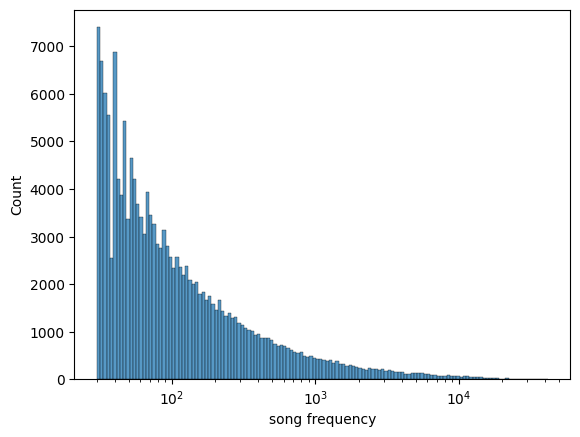

In [6]:
seaborn.histplot(data={"song frequency": frequencies}, x="song frequency", log_scale=True)

Now comes the KS test, for which the null and alternative hypotheses are as follows:

$H_0: F_x(t) = F_0(t)$

$H_1: F_x(t) \neq F_0(t)$

So if we can not reject $H_0$ we can conclude that the data indeed comes from an exponential distribution at a given significance level. I used 95% significance level.

In [7]:
stat, p_value = stats.kstest(frequencies, "expon", args=(loc, scale))

alpha = 0.05

print("Test statistic", stat)
print("p value", p_value)

if p_value < alpha:
    print("We reject the null hypothesis and conclude that the data does not follow an exponential distribution.")
else:
    print("We fail to reject the null hypothesis and conclude that we don't have enough evidence to say the data does not follow an exponential distribution.")

Test statistic 0.3924889147332628
p value 0.0
We reject the null hypothesis and conclude that the data does not follow an exponential distribution.


So it seems that the data does not come from an exponential distribution, my intuition was not correct.

In [8]:
# Helper functions to compute recall values for each playlist
def recall(tp, fn):
    return tp / (tp + fn)

def get_recalls(qrels, recs):
    for (q_id, q_data), (r_id, r_data) in zip(qrels.items(), recs.items()):
        assert q_id == r_id, f"ID mismatch {q_id} {r_id}"
        actual = set(q_data.keys())
        predicted = set(r_data.keys())
        tp = len(actual & predicted)
        fn = len(actual.difference(predicted))
        yield recall(tp, fn)

In [9]:
# compute recalls for the recommendations generated with Algorithm 1 and 2
recall1 = np.array(list(get_recalls(qrels, algo1)))
recall2 = np.array(list(get_recalls(qrels, algo2)))

__Second Hypothesis__

I want to confirm that Algorithm 2 can produce recommendations with higher recall on average with significance level 99%. So the null and alternative hypotheses are as follows:

$H_0: \mu_1 > \mu_2$

$H_1: \mu_1 \leq \mu_2$

If we can reject $H_0$ in favour of $H_1$, we can conclude that Algorithm 2 outperforms Algorithm 1 in terms of recall at significance level 99%.

In [10]:
# check the empirical mean of two arrays
np.mean(recall2), np.mean(recall1)

(0.13159084123043216, 0.013046321769482273)

In [11]:
import numpy as np
from scipy import stats

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(recall2, recall1, alternative='greater')

print("t statistic: ", t_stat)
print("p value: ", p_value)

# Choose significance level
alpha = 0.01

# Interpret the results
if p_value < alpha:
    print("We reject the null hypothesis and conclude that the mean of recall2 is significantly greater than the mean of recall1.")
else:
    print("We fail to reject the null hypothesis and conclude that we don't have enough evidence to say that the mean of recall2 is greater than the mean of recall1.")


t statistic:  246.58068655214413
p value:  0.0
We reject the null hypothesis and conclude that the mean of recall2 is significantly greater than the mean of recall1.


# Distance from origo vs recommendation frequency

In [25]:
def get_recommendation_frequencies(recs):
    recfreq = {}
    for r_data in recs.values():
        for song in r_data.keys():
            if song not in recfreq:
                recfreq[song] = 0
            recfreq[song] += 1
    return recfreq

# compute frequencies
rf = get_recommendation_frequencies(algo2)

In [57]:
import torch
import geoopt
# load weights and compute distances

weights = torch.load("../models/lorentz/model.pt")["encoder.w"]
manifold = geoopt.manifolds.Lorentz()
#distances = torch.sqrt((weights**2).sum(dim=-1)).tolist()
pole = torch.tensor([1.0] + [0] * 15)
distances = manifold.dist(pole, weights)
distances = {idx2song[str(i)]: d for i,d in enumerate(distances)}

In [58]:
rf_dist = np.array([[fr, distances[s]] for s,fr in rf.items()])

Text(0, 0.5, 'Hyperbolic distance from the pole')

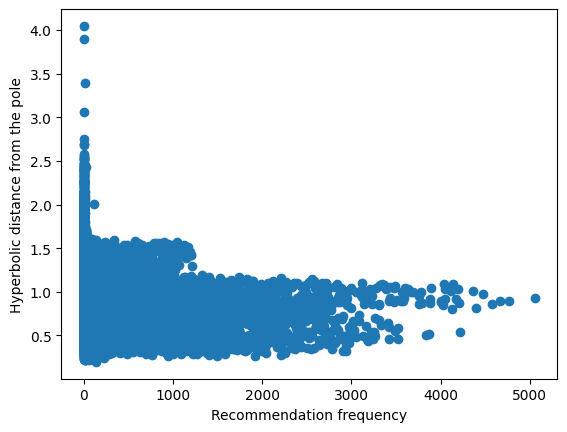

In [59]:
import matplotlib.pyplot as plt

plt.scatter(rf_dist[:, 0], rf_dist[:, 1])
plt.xlabel("Recommendation frequency")
plt.ylabel("Hyperbolic distance from the pole")

# ...

In [ ]:
from functools import reduce
all_songs = set(reduce(list.__add__, [list(pl.keys()) for pl in qrels.values()]))
songs = {s: {"tp": 0, "fp": 0, "fn": 0} for s in all_songs}

In [ ]:
list(songs.items())[:10]

In [ ]:
# count tp, fp, fn for each song, compare them for each algo